# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

In [16]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np

# Import API key
from api_keys import geoapify_key

In [17]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("output_data/cities.csv")

# Display sample data
city_data_df.head()

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,gewane,10.1664,40.6453,85.82,50,15,4.56,ET,1712437973
1,1,narsaq,60.9167,-46.0500,34.02,72,100,1.39,GL,1712437734
2,2,vaini,-21.2000,-175.2000,80.76,69,40,14.97,TO,1712437735
3,3,albany,42.6001,-73.9662,45.03,67,100,4.00,US,1712437762
4,4,katsuura,35.1333,140.3000,57.22,93,99,9.98,JP,1712437975


---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

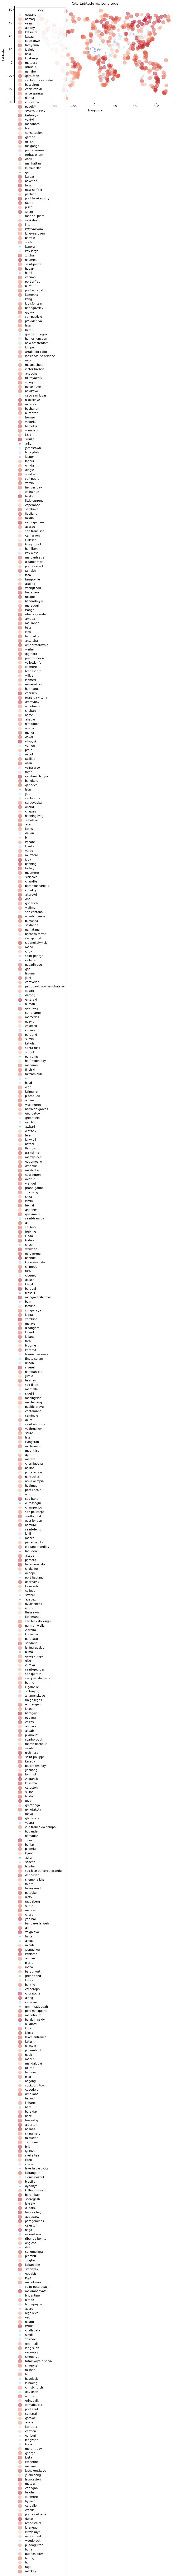

In [20]:
# Define colormap for humidity
cmap = plt.cm.coolwarm

# Define range of dot sizes for humidity levels
min_size = 20
max_size = 200
size_range = np.linspace(city_data_df['Humidity'].min(), city_data_df['Humidity'].max(), 5)
size_bins = np.linspace(min_size, max_size, len(size_range))

# Create scatter plot with a dot for every city
plt.figure(figsize=(10, 6))
for i, row in city_data_df.iterrows():
    # Determine color based on humidity
    color = cmap(row['Humidity'] / 100)
    # Determine dot size based on humidity
    for j in range(len(size_range) - 1):
        if row['Humidity'] >= size_range[j] and row['Humidity'] <= size_range[j + 1]:
            size = size_bins[j]
    # Plot the city with the determined color and size
    plt.scatter(row['Lng'], row['Lat'], s=size, color=color, alpha=0.5, label=row['City'])

# Add labels for the x-axis, y-axis, and title of the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('City Latitude vs. Longitude')

# Add legend with city names
plt.legend(title='City')

# Show the plot
plt.show()


### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [48]:
# Narrow down cities that fit criteria and drop any results with null values
# A max temperature lower than 80 degrees but higher than 70.
# Wind speed less than 10 mph.
# Zero cloudiness.
city_data_df = city_data_df[
    (city_data_df["Max Temp"] < 100)
    & (city_data_df["Max Temp"] > 50)
    & (city_data_df["Wind Speed"] < 10)
    & (city_data_df["Cloudiness"] == 0)
]

# Drop any rows with null values
city_data_df = city_data_df.dropna()

# Display sample data
city_data_df.head()

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
46,46,mar del plata,-38.0023,-57.5575,77.95,49,0,8.99,AR,1712437886
57,57,saint-pierre,-21.3393,55.4781,76.68,83,0,5.75,RE,1712437998
105,105,souillac,-20.5167,57.5167,79.34,89,0,6.04,MU,1712437853
232,232,copiapo,-27.3667,-70.3333,79.70,32,0,6.91,CL,1712437855
254,254,awbari,26.5921,12.7805,73.18,18,0,9.04,LY,1712438080


### Step 3: Create a new DataFrame called `hotel_df`.

In [49]:
# Use the Pandas copy function to create DataFrame called hotel_df to store the city, country, coordinates, and humidity
hotel_df = city_data_df[["City", "Country", "Lat", "Lng","Humidity"]].copy()

# Add an empty column, "Hotel Name," to the DataFrame so you can store the hotel found using the Geoapify API
hotel_df["Hotel Name"] = ""

# Display sample data
hotel_df.head()

,City,Country,Lat,Lng,Humidity,Hotel Name
46,mar del plata,AR,-38.0023,-57.5575,49,
57,saint-pierre,RE,-21.3393,55.4781,83,
105,souillac,MU,-20.5167,57.5167,89,
232,copiapo,CL,-27.3667,-70.3333,32,
254,awbari,LY,26.5921,12.7805,18,


### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [80]:
import requests
from api_keys import geoapify_key

# Set parameters to search for a hotel
radius = 10000
base_url = "https://api.geoapify.com/v2/places"

# Print a message to follow up the hotel search
print("Starting hotel search")

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iterrows():
    # get latitude, longitude from the DataFrame
    lat = row["Lat"]
    lng = row["Lng"]

    # Set filter and bias parameters with the current city's latitude and longitude to the params dictionary
    params = {
        "categories": "accommodation.hotel",
        "limit": 10,
        "filter": f"circle:{lng},{lat},{radius}",
        "bias": f"proximity:{lng},{lat}",
        "api_key": geoapify_key
    }
    
    # Make an API request using the params dictionary
    response = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = response.json()
    
    # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        hotel_name = name_address["features"][0]["properties"]["name"]
        hotel_df.loc[index, "Hotel Name"] = hotel_name
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel Name"] = "No hotel found"
        
    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel Name']}")

# Display sample data
hotel_df


Starting hotel search
mar del plata - nearest hotel: Gran hotel Mónaco
saint-pierre - nearest hotel: Tropic Hotel
souillac - nearest hotel: Hotel SkylineInn
copiapo - nearest hotel: Hotel Diego de Almeida
awbari - nearest hotel: فندق اوباري
grand gaube - nearest hotel: Hotel Lux- Grand Gaube
bandar-e lengeh - nearest hotel: Old owner do not like foreigners hotel
minab - nearest hotel: هتل صدف
cockburn town - nearest hotel: The Salt Raker Inn
linhares - nearest hotel: Days Inn Linhares
ayodhya - nearest hotel: Birla Dharamshala
rock sound - nearest hotel: Rock Sound Club


,City,Country,Lat,Lng,Humidity,Hotel Name
46,mar del plata,AR,-38.0023,-57.5575,49,Gran hotel Mónaco
57,saint-pierre,RE,-21.3393,55.4781,83,Tropic Hotel
105,souillac,MU,-20.5167,57.5167,89,Hotel SkylineInn
232,copiapo,CL,-27.3667,-70.3333,32,Hotel Diego de Almeida
254,awbari,LY,26.5921,12.7805,18,فندق اوباري
268,grand gaube,MU,-20.0064,57.6608,91,Hotel Lux- Grand Gaube
436,bandar-e lengeh,IR,26.5579,54.8807,57,Old owner do not like foreigners hotel
441,minab,IR,27.1467,57.0801,67,هتل صدف
473,cockburn town,TC,21.4612,-71.1419,75,The Salt Raker Inn
477,linhares,BR,-19.3911,-40.0722,78,Days Inn Linhares


In [44]:
hotel_df_cleaned = hotel_df.dropna()

In [81]:
hotel_df.head()

,City,Country,Lat,Lng,Humidity,Hotel Name
46,mar del plata,AR,-38.0023,-57.5575,49,Gran hotel Mónaco
57,saint-pierre,RE,-21.3393,55.4781,83,Tropic Hotel
105,souillac,MU,-20.5167,57.5167,89,Hotel SkylineInn
232,copiapo,CL,-27.3667,-70.3333,32,Hotel Diego de Almeida
254,awbari,LY,26.5921,12.7805,18,فندق اوباري


### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

In [82]:
import folium

# Create a map centered around the mean latitude and longitude of the data
map_hotel = folium.Map(location=[hotel_df['Lat'].mean(), hotel_df['Lng'].mean()], zoom_start=2)

# Iterate through the DataFrame and add markers to the map
for _, row in hotel_df.iterrows():
    # Define popup text with additional information
    popup_text = f"Hotel Name: {row['Hotel Name']}<br>City: {row['City']}<br>Country: {row['Country']}<br>Humidity: {row['Humidity']}<br>Latitude: {row['Lat']}<br>Longitude: {row['Lng']}"
    
    # Create marker with popup
    marker = folium.Marker(location=[row['Lat'], row['Lng']], popup=popup_text)
    
    # Add marker to the map
    marker.add_to(map_hotel)

# Display the map
map_hotel


In [75]:
unique_hotel_names = hotel_df["Hotel Name"].unique()
print(unique_hotel_names)

['Gran hotel Mónaco' 'Tropic Hotel' 'Hotel SkylineInn'
 'Hotel Diego de Almeida' 'فندق اوباري' 'Hotel Lux- Grand Gaube'
 'Old owner do not like foreigners hotel' 'هتل صدف' 'The Salt Raker Inn'
 'Days Inn Linhares' 'Birla Dharamshala' 'Rock Sound Club']
